# SciPy Optimize
*Last updated by Arthur Ryman on  2022-05-29*

## Introduction

I have run into a problem in `RWC_alam()`. The SymPy solvers fails for certain values of parameters.
The solvers seek to find an exact solution but all we really need is a good approximation to the optimal
value of $a_0$.

The goal of this notebook is to determine if the SciPy `optimize` module can find decent values.

## Simple Example

Recreate the simple example given in https://realpython.com/python-scipy-cluster-optimize/#using-the-optimize-module-in-scipy.

We can try `minimize_scalar()` and `root_scalar()`.

In [1]:
from scipy.optimize import minimize_scalar

def objective_function(x):
    return 3 * x ** 4 - 2 * x + 1

objective_function(0.55)

0.17451875000000006

In [2]:
import numpy as np
import pandas as pd

xs = np.arange(0, 1.01, 0.01)
x_index = pd.Index(xs, name='x')
df = pd.DataFrame(index=x_index)

In [3]:
df['y'] = [objective_function(x) for x in xs]

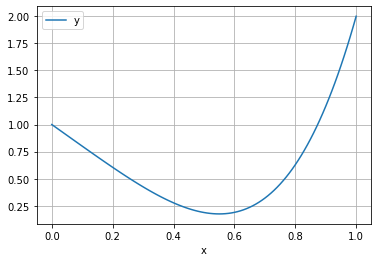

In [4]:
df.plot(grid=True);

In [5]:
res = minimize_scalar(objective_function)
res

     fun: 0.17451818777634331
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 16
     nit: 12
 success: True
       x: 0.5503212087491959

## `RWC_alam()`

In this case we are trying to find optimal values of the parameters $a$ and $\lambda_v$
that minimize the expectation value $E$ of the RWC Hamiltonian defined by $(B, c_1, c_2)$
on the ground state defined by $(a, \lambda_v)$ where $\lambda_v$ is a function of $a$.

The paper WR2015 gives the following equations for the case $v = 0$.

In [6]:
from acmpy.papers.wr2015 import *

Eq_B16

Eq(E, B*c1*lambda0/(2*a**2) + B*c2*lambda0*(lambda0 + 1)/(2*a**4) + a**2*(1 + 9/(4*lambda0 - 4))/(2*B))

In [7]:
Eq_B11

Eq(lambda0, sqrt(a**4*beta0**4 + 9/4) + 1)

In [8]:
Eq_B15

Eq(beta0, Piecewise((sqrt(2)*sqrt(-c1/c2)/2, c1 < 0), (0, True)))

In [9]:
def make_E_a(B, c1, c2):
    beta0 = float(beta0_B15(c1, c2))
    def E_a(a):
        lambda0 = float(lambda0_B11(a, beta0))
        return float(E_B16(a, lambda0, B, c1, c2))
    return E_a

E_a_10 = make_E_a(10, -3, 2)
E_a_10(1)

58.39784678619764

In [10]:
a_index = pd.Index(np.arange(1.0, 10.1, 0.1), name='a')
E_df = pd.DataFrame(index=a_index)

In [11]:
E_df['B=10'] = [E_a_10(a) for a in a_index]

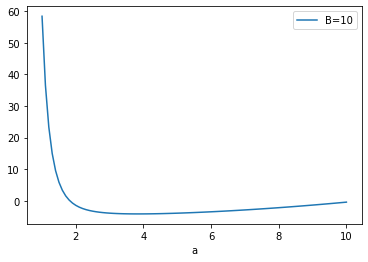

In [12]:
E_df.plot();

In [13]:
res_10 = minimize_scalar(E_a_10, bracket=(1, 10))
res_10

     fun: -4.124033118347146
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 21
     nit: 17
 success: True
       x: 3.835914396554969

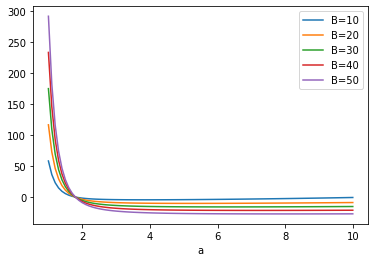

In [14]:
res_B = dict()
for B in range(20, 60, 10):
    name_B = f'B={B}'
    E_a_B = make_E_a(B, -3, 2)
    E_df[name_B] = [E_a_B(a) for a in a_index]
    res_B[B] = minimize_scalar(E_a_B, bracket=(1, 100))
E_df.plot();

In [15]:
for B in res_B:
    print('=' * 20)
    print(f'B={B}')
    print(res_B[B])

B=20
     fun: -9.885134142691431
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 22
     nit: 18
 success: True
       x: -5.202970554521825
B=30
     fun: -15.556448068718904
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 22
     nit: 18
 success: True
       x: 6.27313670563223
B=40
     fun: -21.204764227311554
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 23
     nit: 19
 success: True
       x: 7.184399509043185
B=50
     fun: -26.84380093848864
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 22
     nit: 18
 success: True
       x: 7.992004371274268


## Use $A = a^2$

The above looks promising but the behavior might improve if we optimize with respect to $A = a^2$.

In [16]:
A_index = pd.Index(np.arange(0.1, 30.1, 0.1), name='A')
E_A_df = pd.DataFrame(index=A_index)

In [17]:
import math
def make_E_A(B, c1, c2):
    beta0 = float(beta0_B15(c1, c2))
    def E_A(A):
        a = math.sqrt(A)
        lambda0 = float(lambda0_B11(a, beta0))
        return float(E_B16(a, lambda0, B, c1, c2))
    return E_A

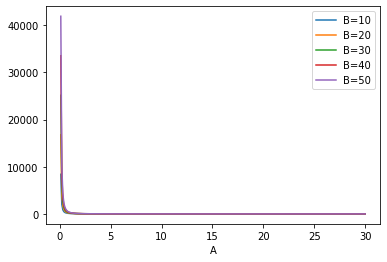

In [18]:
res_A_B = dict()
for B in range(10, 60, 10):
    name_B = f'B={B}'
    E_A_B = make_E_A(B, -3, 2)
    E_A_df[name_B] = [E_A_B(A) for A in A_index]
    res_A_B[B] = minimize_scalar(E_A_B, bracket=(1, 10))
E_A_df.plot();

In [19]:
for B in res_A_B:
    print('=' * 20)
    print(f'B={B}')
    print(res_A_B[B])

B=10
     fun: -4.124033118347147
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 17
     nit: 13
 success: True
       x: 14.714238242291719
B=20
     fun: -9.885134142691431
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 22
     nit: 16
 success: True
       x: 27.070903137123604
B=30
     fun: -15.556448068718897
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 20
     nit: 13
 success: True
       x: 39.35224839442481
B=40
     fun: -21.204764227311564
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 21
     nit: 13
 success: True
       x: 51.615594870767886
B=50
     fun: -26.843800938488656
 message: '\nOpt

My intuition was wrong. 
Using $A$ instead of $a$ stretches out the x-axis so the
objective function changes more slowly.

## SciPy `root_scalar()`

The `RWC_alam()` function finds the zeros of the derivative of the expectation value
with respect to $A$.
The SciPy `root_scalar()` function is therefore a direct replacement for Maple `fsolve()`
or SymPy `solve()`, `solveset()`, or `nsolve()`.

First, use `root_scalar()` to find a root of a simple polynomial.

In [20]:
def poly(x: float) -> float:
    return (x - 1) * (x - 2) * (x - 3)

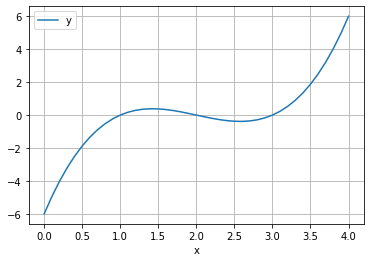

In [21]:
xs = np.arange(0.0, 4.1, 0.1)
x_index = pd.Index(xs, name='x')
poly_df = pd.DataFrame(index=x_index)
poly_df['y'] = [poly(x) for x in xs]
poly_df.plot(grid=True);

In [22]:
from scipy.optimize import root_scalar, RootResults

results = root_scalar(poly, bracket=(2.1, 10.0))
results

      converged: True
           flag: 'converged'
 function_calls: 16
     iterations: 15
           root: 3.0000000000001217

In [23]:
results.root

3.0000000000001217

Next, find a root of the function `RWC_alam()` tries to solve.
The function is defined in terms of the real, positive
variable $A = a^2$.

In [24]:
from sympy import Symbol

A = Symbol('A', real=True, positive=True)
A

A

The function also depends on the real, positive parameter $B$.
We'll vary $B$ since the behaviour of `solveset()` etc. was sensitive to its value.

In [25]:
B = Symbol('B', real=True, positive=True)
B

B

Use the following fixed parameter values for $c_1, c_2, v$.

In [26]:
c1_value = -3.0
c2_value = 2.0
v_value = 0

In [27]:
from acmpy.hamiltonian_data import muf, RWC2

mu_A = muf(A, c1_value, c2_value, v_value)
mu_A

3*sqrt(0.25*A**2 + 1)

In [28]:
F2_A_B = RWC2(A, mu_A, B, c1_value, c2_value, v_value)
F2_A_B

-20.25*A**5/(2.25*A**2 + 9) - 6.75*A**3*B**2 + A**3*(6*sqrt(0.25*A**2 + 1) + 9) + 4.5*A**2*B**2*(3*sqrt(0.25*A**2 + 1) + 3) - 3*B**2*sqrt(0.25*A**2 + 1)*(3*sqrt(0.25*A**2 + 1) + 2)*(-3.0*A + 6.0*sqrt(0.25*A**2 + 1) + 8.0)

In [29]:
F2_df = pd.DataFrame(index=A_index)
F2_df

""
A
0.1
0.2
0.3
0.4
0.5
...
29.6
29.7
29.8


In [30]:
from sympy import Expr

def make_F2_A(B_value: float) -> Expr:
    return F2_A_B.subs(B, B_value)

F2_A_10 = make_F2_A(10)
F2_A_10

-20.25*A**5/(2.25*A**2 + 9) + A**3*(6*sqrt(0.25*A**2 + 1) + 9) - 675.0*A**3 + 450.0*A**2*(3*sqrt(0.25*A**2 + 1) + 3) - 300*sqrt(0.25*A**2 + 1)*(3*sqrt(0.25*A**2 + 1) + 2)*(-3.0*A + 6.0*sqrt(0.25*A**2 + 1) + 8.0)

In [31]:
from typing import Callable

def make_F2(B_value: float) -> Callable[[float], float]:
    F2_A: Expr = make_F2_A(B_value)
    def F2(A_value: float) -> float:
        return float(F2_A.subs(A, A_value))
    return F2

In [32]:
F2_10 = make_F2(10)
F2_df['B=10'] = [F2_10(A_value) for A_value in A_index]
F2_df

,B=10
A,
0.1,-2.057600e+04
0.2,-2.020296e+04
0.3,-1.987917e+04
0.4,-1.960280e+04
0.5,-1.937189e+04
...,...
29.6,1.834623e+06
29.7,1.863034e+06
29.8,1.891753e+06


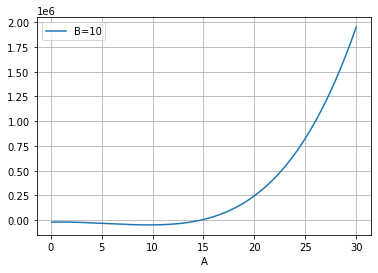

In [33]:
F2_df.plot(grid=True);

Investigate the zeroes of $F2$ as $B$ varies.

In [34]:
Bs = list(range(10, 21, 2))
Bs

[10, 12, 14, 16, 18, 20]

In [35]:
for B_value in Bs:
    F2 = make_F2(B_value)
    F2_df[f'B={B_value}'] = [F2(A_value) for A_value in A_index]

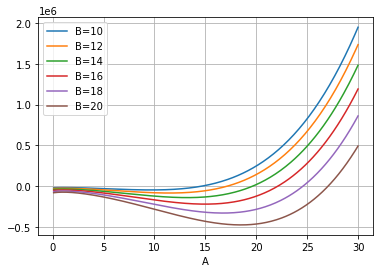

In [36]:
F2_df.plot(grid=True);

Use `scalar_root()` to find the zeros of `F2()`.

In [37]:
for B_value in range(10, 101, 10):
    F2 = make_F2(B_value)
    result = root_scalar(F2, bracket=(1, 2 * B_value))
    print('=' * 40, f'B={B_value}')
    print(result)

======================================== B=10
      converged: True
           flag: 'converged'
 function_calls: 12
     iterations: 11
           root: 14.714238439477397
======================================== B=20
      converged: True
           flag: 'converged'
 function_calls: 13
     iterations: 12
           root: 27.07090315842021
======================================== B=30
      converged: True
           flag: 'converged'
 function_calls: 14
     iterations: 13
           root: 39.35224490248067
======================================== B=40
      converged: True
           flag: 'converged'
 function_calls: 14
     iterations: 13
           root: 51.615592277620486
======================================== B=50
      converged: True
           flag: 'converged'
 function_calls: 14
     iterations: 13
           root: 63.87213284554001
======================================== B=60
      converged: True
           flag: 'converged'
 function_calls: 14
     iterations: 13
 

## Conclusion

The SciPy `root_scalar()` function works well. However, it does
require that I specify the `bracket` argument so I need to find a good
estimate for the interval in which the zero occurs.
My first approximation is $(1, 2B)$ but this might depend on $c_1, c_2, v$.

A pragmatic approach is to perform a binary search for the bounds since we know
the function starts negative and then goes positive.

In [38]:
F2_A_B

-20.25*A**5/(2.25*A**2 + 9) - 6.75*A**3*B**2 + A**3*(6*sqrt(0.25*A**2 + 1) + 9) + 4.5*A**2*B**2*(3*sqrt(0.25*A**2 + 1) + 3) - 3*B**2*sqrt(0.25*A**2 + 1)*(3*sqrt(0.25*A**2 + 1) + 2)*(-3.0*A + 6.0*sqrt(0.25*A**2 + 1) + 8.0)

In [39]:
F2_A_B.subs(A, 0).evalf()

-210.0*B**2

In [40]:
A, B, c1, c2, v

(A, B, c1, c2, v)

In [41]:
mu_A_c1_c2_v = muf(A, c1, c2, v)
mu_A_c1_c2_v

sqrt(A**2*c1**2/c2**2 + (2*v + 3)**2)

In [42]:
F2_A_B_c1_c2_v = RWC2(A, mu_A_c1_c2_v, B, c1, c2, v)
F2_A_B_c1_c2_v

A**3*((2*v + 3)**2 + 2*sqrt(A**2*c1**2/c2**2 + (2*v + 3)**2)) - B**2*(A*c1 + c2*(sqrt(A**2*c1**2/c2**2 + (2*v + 3)**2) + 4))*sqrt(A**2*c1**2/c2**2 + (2*v + 3)**2)*(sqrt(A**2*c1**2/c2**2 + (2*v + 3)**2) + 2) + c1**2*(-A**5*(2*v + 3)**2/(A**2*c1**2/c2**2 + (2*v + 3)**2) + A**3*B**2*c1 + A**2*B**2*c2*(sqrt(A**2*c1**2/c2**2 + (2*v + 3)**2) + 3))/c2**2

In [43]:
F2_A_B_c1_c2_v.subs(A, 0)

-B**2*c2*(2*v + 3)*(2*v + 5)*(2*v + 7)

In [44]:
from sympy import O, oo, limit
O(F2_A_B_c1_c2_v, (A, oo))

O(A**4/c2, (A, oo))

In [45]:
limit(F2_A_B_c1_c2_v / A ** 4, A, oo)

2*Abs(c1)/c2